# Forecasting with convolutional networks

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import RMSE, Baseline, GroupNormalizer, TemporalConvolutionalNetwork, TimeSeriesDataSet
from pytorch_forecasting.data.examples import get_stallion_data

In [3]:
data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


For the definition of the TimeSeriesDataSet it is important to fix the encoder and prediction/decoder length, i.e. set the minimum and maximum to the same value.

In [4]:
max_prediction_length = 3
max_encoder_length = 12
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"],  # transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer()

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [6]:
tcn = TemporalConvolutionalNetwork.from_dataset(
    dataset=training,
    conv_dropout=0.1,
    hidden_layer_sizes=[64, 32, 16],
    kernel_size=3,
    fc_dropout=0.1,
    loss=RMSE(),
    learning_rate=0.01,
)
print(f"Number of parameters in network: {tcn.size()/1e3:.1f}k")

Number of parameters in network: 42.1k



  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | RMSE           | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | input_embeddings | MultiEmbedding | 1.3 K 
3 | network          | Sequential     | 40.8 K
4 | output_layer     | Linear         | 51    
----------------------------------------------------
42.1 K    Trainable params
0         Non-trainable params
42.1 K    Total params
0.168     Total estimated model params size (MB)
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /Users/beitnerjan/Documents/Github/temporal_fusion_transformer_pytorch/lr_find_temp_model.ckpt


suggested learning rate: 1.5848931924611133e-07


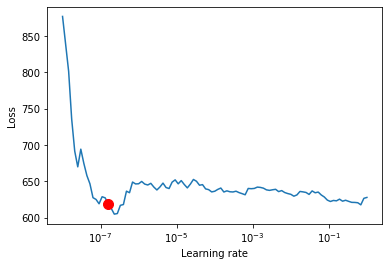

In [7]:
# find optimal learning rate
res = trainer.tuner.lr_find(tcn, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-8)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs", name="tcn")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=32,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tcn = TemporalConvolutionalNetwork.from_dataset(
    dataset=training,
    conv_dropout=0.1,
    hidden_layer_sizes=[64, 32, 16],
    kernel_size=3,
    fc_dropout=0.1,
    loss=RMSE(),
    learning_rate=1e-7,
    log_interval=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(
    tcn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | RMSE           | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | input_embeddings | MultiEmbedding | 1.3 K 
3 | network          | Sequential     | 40.8 K
4 | output_layer     | Linear         | 51    
----------------------------------------------------
42.1 K    Trainable params
0         Non-trainable params
42.1 K    Total params
0.168     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/beitnerjan/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [10]:
tcn.predict(val_dataloader)

tensor([[9.2319e+01, 7.8627e+01, 9.7021e+01],
        [7.6016e+01, 6.1730e+01, 8.0932e+01],
        [4.6172e+01, 3.8030e+01, 4.8966e+01],
        ...,
        [2.0844e+03, 1.9554e+03, 2.1288e+03],
        [7.5281e+01, 6.9230e+01, 7.7362e+01],
        [1.2065e+00, 7.0606e-01, 1.3785e+00]])

In [11]:
# calcualte mean absolute error on validation set with baseline
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = Baseline().predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(326.6887)

In [12]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalConvolutionalNetwork.load_from_checkpoint(best_model_path)

In [13]:
# calcualte mean absolute error on validation set with tcn
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tcn.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(375.9577)

Let's now plot a couple of forecast examples using the best available model

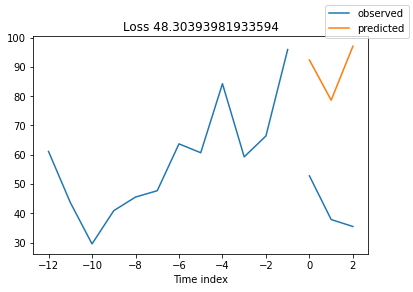

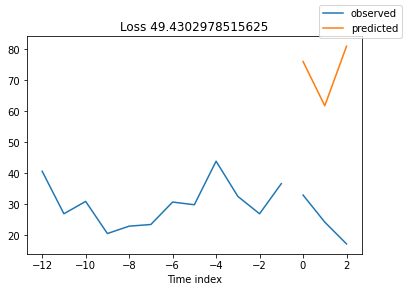

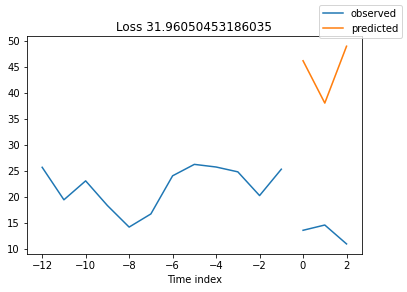

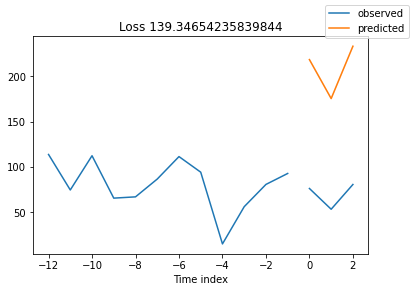

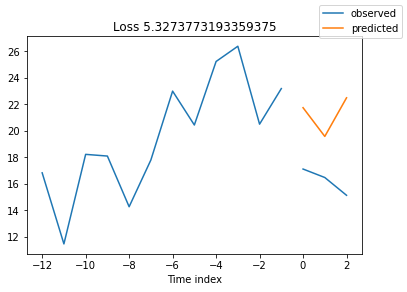

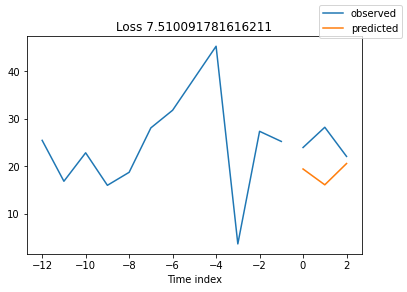

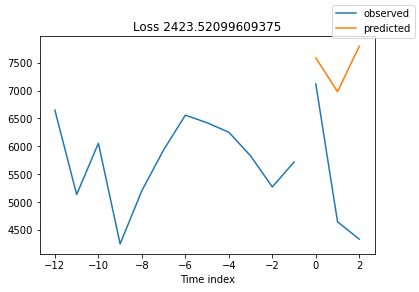

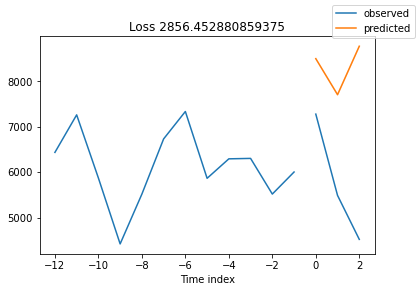

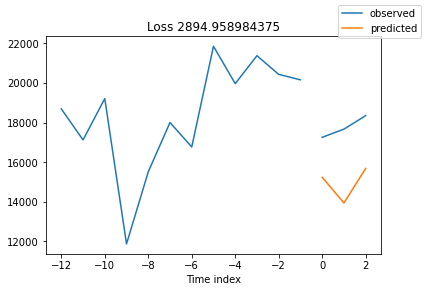

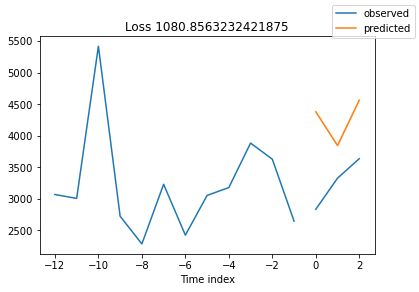

In [14]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);